# Mistaken Mice notebook

2020 NMA academy project, mistaken mice group, pod 173 antique cicada

# Import packages and functions

In [1]:
# to import the functions we wrote, clone the git repo
# !git clone https://github.com/jorgeerrz/mistaken_mice.git
# %cd mistaken_mice
#alternatively, run the notebook locally, then just comment the lines above

from filter import *
from summarise_dataset import *
from PCA_fun import neurons_PCA
from GLM import *

%load_ext autoreload
%autoreload 2

# Loading of Steinmetz data

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)


In [3]:
# skip if you already downloaded the data
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [4]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


# Filter the data

In [5]:
# need to loop over all sessions to pass as input to summarise_data function in next step
first_session_filtered_VISp = filter_spikes(alldat,0,'VISp') 
first_session_filtered = filter_spikes(alldat,0) 
print(np.shape(first_session_filtered['spks']))

(734, 10, 250)


# Summarise the filtered data

{'n_neurons': array([ 734., 1070.,  619., 1769., 1077., 1169.,  584., 1156.,  788.,
        1172.,  857.,  698.,  983.,  756.,  743.,  474.,  565., 1089.,
         606.,  899.,  578.,  646., 1268., 1337.,  885., 1056.,  563.,
         549.,  750.,  942.,  977.,  522.,  613.,  781.,  795.,  680.,
        1055.,  805., 1348.]),
 'n_trials': array([214., 251., 228., 249., 254., 290., 252., 250., 372., 447., 342.,
        340., 300., 268., 404., 280., 224., 316., 247., 235., 124., 444.,
        151., 187., 261., 178., 253., 142., 128., 143., 237., 260., 191.,
        296., 311., 258., 181., 199., 343.]),
 'n_timebins': array([250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250.])}

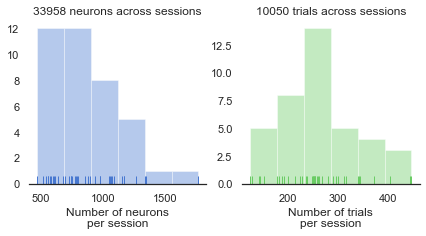

In [6]:
summarise_dataset(alldat) # should be filtered data, but alldat is used here as an example


# Change the time bin
Optional step

In [18]:
dat = first_session_filtered
NT = dat['spks'].shape[-1]
minT = 50
maxT = 130
NN = dat['spks'].shape[0]

droll = np.reshape(dat['spks'][:,:,minT:maxT], (NN,-1))

dat['spks'][:,:,minT:maxT].mean(axis=2).shape


(734, 10)

# Principal Component Analysis
For now, just one session

{'spks': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 1, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0

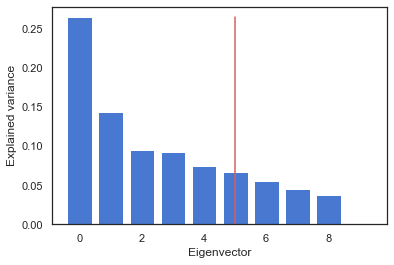

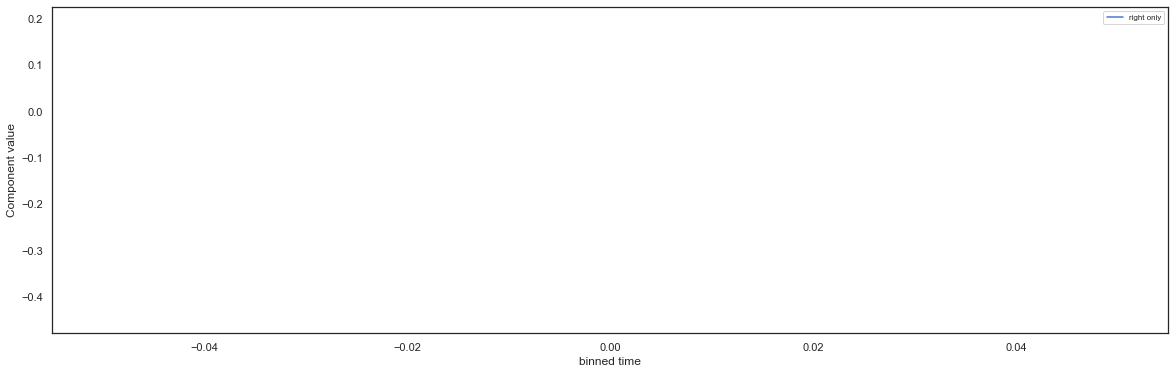

In [8]:
neurons_PCA(first_session_filtered,0.1,50,130)

# General Linear Model 

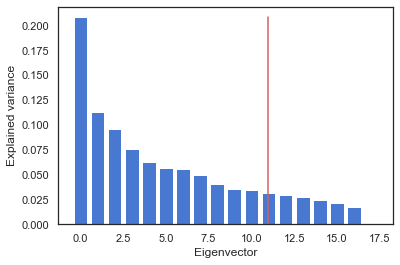

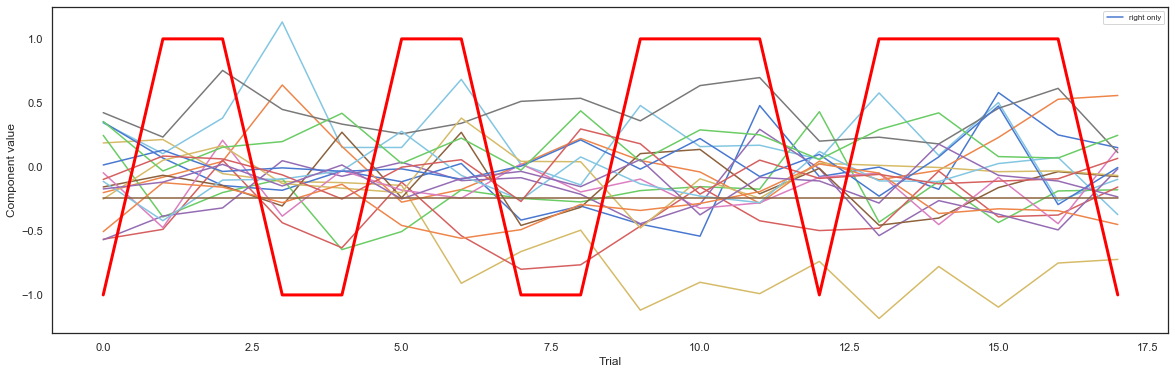

In [33]:
session = 11
filtered = filter_spikes(alldat,session)
dat = neurons_PCA( filter_spikes(alldat,session),0.1,50,130)
plt.plot(dat['PCs'].T)
plt.xlabel('Trial')
plt.ylabel('Component value')
dat['PCs'].shape
plt.plot(filter_spikes(alldat,session)['chcs'],linewidth=3,c='red')


array([-1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.])

(276, 276)

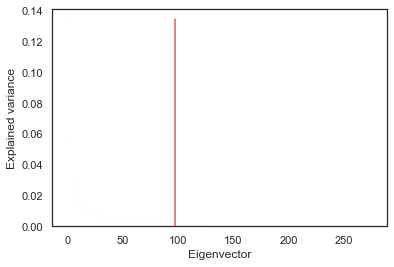

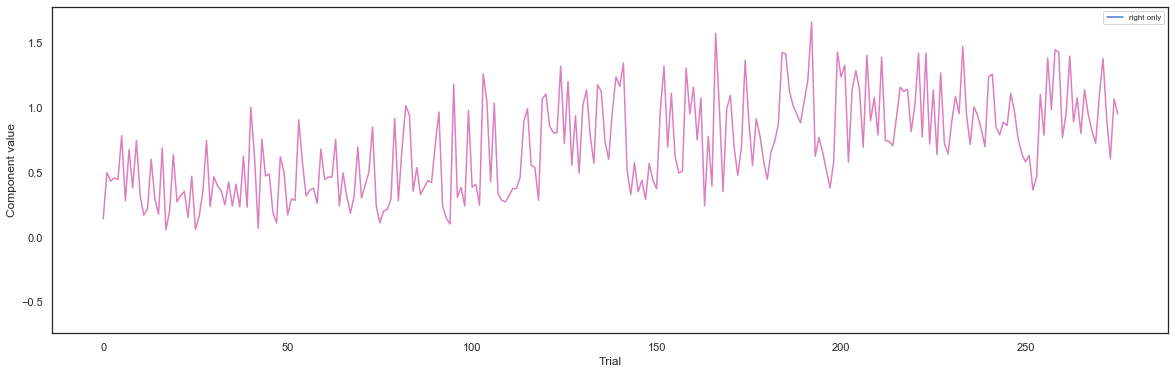

In [127]:
session = 11
filtered = filter_spikes(alldat,session,unfair_only=False)
dat = neurons_PCA(filtered ,0.1,50,130)
plt.plot(dat['PCs'][0,:])



plt.xlabel('Trial')
plt.ylabel('Component value')
dat['PCs'].shape

IndexError: tuple index out of range

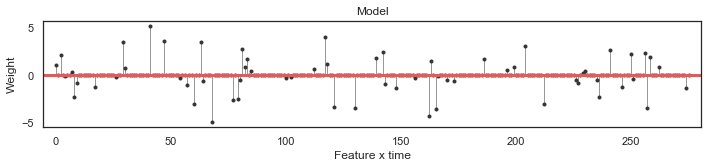

In [135]:

    
logreg = GLM_logistic(dat['PCs'], filtered['chcs'], pen = "l1", lambda_L2 = 3)


ValueError: setting an array element with a sequence.

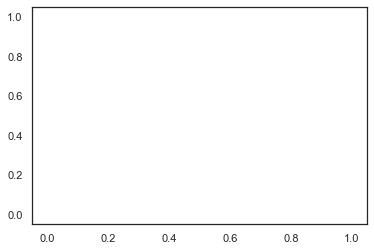

In [76]:
ax = plt.subplot()
ax.plot()
ax.stem(logreg.coef_.squeeze(), use_line_collection=True)


(3, 4)

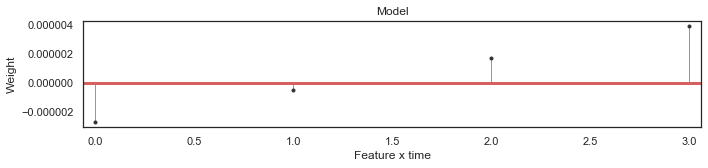

In [109]:
x = np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9],[10, 11, 12]])
y = np.array([0, 1, 0])
logreg = GLM_logistic(x.T, y, pen = "l2", lambda_L2 = 1)
plot_weights({"Model":logreg})

x.T.shape